# 2024-10-03 Flfl Analysis

- This notebook visualizes the data from the _Falafel[795]_ mutant live cell data. 
- These values were manually anotated from Imaris and normalization/calculations were done in excel.
    - The background pixel value was 100 for both channels, and normalization against the cytoplasm was done with a value of 150 for cytoplasmic RFP intensity.
    - This was done because the RFP signal is statistically similar across cells, so a base value of 150 for all cells made for easier quantification.
    - The AC/BC ratio is done using values after background subtraction.
- These values are then plotted using `seaborn` `stripplots` and `boxplots`.
- Statistical tests are done and recorded in a summary table at the end of the notebook.  

In [1]:
# Loading in standard libraries and functions

### --- REMOVE PRINT FUNCTION: --- ### 

# Makes it so any variable or statement on it's own line gets printed w/o print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

### --- IMPORT LIBRARIES: --- ###

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
#import altair as alt
import os
import glob
import matplotlib.patches as mpatches
# We're also going to tell Jupyter to use inline plotting instead of notebook plotting
# It basically means you don't have to use plt.show() in every cell
%matplotlib inline
import re

### --- CONJ 510 SUMMARY TABLES: --- ### 

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

#summary = fil.groupby('condition').agg(['mean', 'std', 'min', 'max', 'median', percentile(25), percentile(75), 'skew'])
#summary

### --- IMPORT SCIPY T TEST: --- ###

from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
from scipy.stats import t

### --- IND. T-TEST FUNCTION: --- ###
# source: https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/

def independent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = mean(data1), mean(data2)
    # calculate standard errors
    se1, se2 = sem(data1), sem(data2)
    # standard error on the difference between the samples
    sed = sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = len(data1) + len(data2) - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

### --- 3D CARTESIAN DISTANCE FUNCTION: --- ###

# AB = sqrt((x2 - x1)^2  +   (y2 - y1)^2   +   (z2 - z1)^2)

def cart3D_dist(x1, x2, y1, y2, z1, z2):
    x_dif = x2-x1
    y_dif = y2-y1
    z_dif = z2-z1
    x_sqr = x_dif**2
    y_sqr = y_dif**2
    z_sqr = z_dif**2
    dist = sqrt(x_sqr + y_sqr + z_sqr)
    return dist

### --- FINDING UNIQUE COMBINATIONS FUNCTION: --- ###

# Based on the mathematical concept of finding unique combinations without selecting the same option again. 
# n is the dataset to be pulled from
# r is the number of data to select from the dataset 
def find_combos(n, r):
    return (math.factorial(n))/((math.factorial(r))*(math.factorial(n-r)))

### --- ANGLE BETWEEN TWO 2D LINES FUNCTION: --- ###

import math

# defining function for calculating angle of rotation between 2 2D lines
def find_angle(m1, m2): 
    angle = math.degrees(math.atan(abs((m1 - m2)/(1 + m1*m2))))
    return angle

### --- SLOPE BETWEEN TWO POINTS ON A 2D LINE FUNCTION: --- ###

# defining a function to calculate slope

def find_slope(y2, y1, x2, x1):
    m = (y2 - y1)/(x2 - x1)
    return m

### --- SET UP FOR A FIGURE: --- ###

# fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols = 2,
#                                                         nrows = 3,
#                                                         sharex = False,
#                                                         sharey = True,
#                                                         figsize = (40,50))

#titlefont = 40 # sets font size 
#axisfont = 30
#plt.rc('xtick', labelsize=25) 
#plt.rc('ytick', labelsize=25) 
#palette = ['#5DADE2', '#EC7063', '#F8C471']
#fig_title = 'ACD Timing in WT and pp4KO neuroblasts'


### --- SET UP FOR CUSTOM LEGENDS --- ###

#colors = ["g", "w"]
#texts = ["Green Data Description", "RedData Description"]
#patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
#plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.5), loc='center', ncol=2 )


### --- color palettes --- ###

# p = ['#3386FF', '#FF5733'] # classic blue and orange from the rotation saga
# ['#3386FF', '#143566', 'grey'] # hex codes for blue, dark blue, grey
# ['#FF5733', '#99341e', 'grey'] # hex codes for orange, dark orange, grey
# ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000'] #blue, purple, magenta, orange, and yellow palette for color blindness

### --- PLOT STYLES: --- ###

plt.style.use('fast') # uses seaborn style
#sns.set_style('white') # uses blank white background style (to copy PRISM)

### --- REMOVING DATAFRAME VIEW LIMITS --- ###
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Command line cells to ensure code is in right directory. 

In [2]:
pwd

'/Users/rcsegura/Desktop/PP4_github/Supp Fig1'

In [3]:
ls

2024-07-02 PP4r2.ipynb          figs/
2024-10-03 Flfl analysis.ipynb  output/
data/


In [4]:
home_dir = '/Users/rcsegura/Desktop/PP4_github/Supp Fig1' # home directory
figs_dir = home_dir + '/figs/' # directory to hold the figure output
data_dir = home_dir + '/data/' # directory holding the data
outs_dir = home_dir + '/output/' # directory to save any output csv files to 

In [5]:
# reading in data
os.chdir(data_dir)
data = pd.read_excel('Flfl data.xlsx')
data.head(5)

,file name,genotype,phase,AC RFP mean,BC RFP mean,AC RFP norm,BC RFP norm,AC/BC
0,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,947.675,376.914,5.651167,1.846093,3.515319
1,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,991.105,513.405,5.940700,2.756033,2.314511
2,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,1006.840,611.579,6.045600,3.410527,1.856324
3,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,756.283,428.459,4.375220,2.189727,2.177279
4,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,869.279,500.579,5.128527,2.670527,2.051689


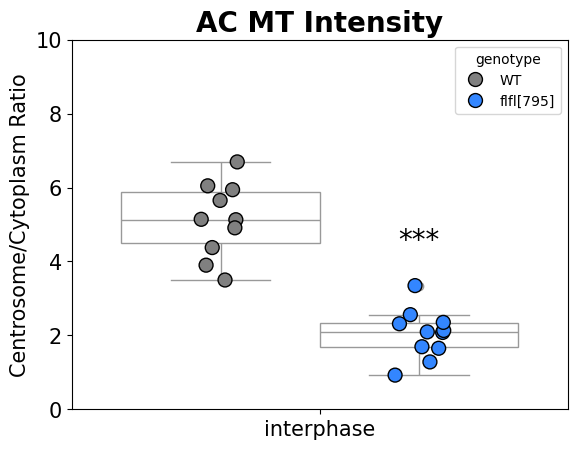

In [6]:
# plotting
o = ['interphase']
ho = ['WT', 'flfl[795]']
p = ['grey', '#3386FF']

sns.stripplot(x = 'phase', y = 'AC RFP norm', data = data,
             hue = 'genotype', hue_order = ho, order = o, palette = p,
             dodge = True, legend = True,
             linewidth = 1, edgecolor = 'k', size = 10);

sns.boxplot(x = 'phase', y = 'AC RFP norm', data = data,
             hue = 'genotype', hue_order = ho, order = o, palette = ['w', 'w'],
             dodge = True, legend = False);

# stat time, interphase
param1 = data[(data['genotype']=='WT') & (data['phase']=='interphase')]['AC RFP norm']
param2 = data[(data['genotype']=='flfl[795]') & (data['phase']=='interphase')]['AC RFP norm']
int_p = independent_ttest(param1, param2, 0.05)[3]

if int_p < 0.001:
    plt.annotate('***', fontsize = 20, ha = 'center', xy = (0.2, param2.max()+1))
elif int_p < 0.01:
    plt.annotate('**', fontsize = 20, ha = 'center', xy = (0.2, param2.max()+1))
elif int_p < 0.05:
    plt.annotate('*', fontsize = 20, ha = 'center', xy = (0.2, param2.max()+1))
elif int_p > 0.05:
    plt.annotate(f"ns, p = {int_p}", fontsize = 10, ha = 'center', xy = (0.2, param2.max()+1))

# stat time, prometaphase
param1 = data[(data['genotype']=='WT') & (data['phase']=='prometaphase')]['AC RFP norm']
param2 = data[(data['genotype']=='flfl[795]') & (data['phase']=='prometaphase')]['AC RFP norm']
int_p = independent_ttest(param1, param2, 0.05)[3]

if int_p < 0.001:
    plt.annotate('***', fontsize = 20, ha = 'center', xy = (1.2, param2.max()+1))
elif int_p < 0.01:
    plt.annotate('**', fontsize = 20, ha = 'center', xy = (1.2, param2.max()+1))
elif int_p < 0.05:
    plt.annotate('*', fontsize = 20, ha = 'center', xy = (1.2, param2.max()+1))
elif int_p > 0.05:
    plt.annotate(f"ns, p = {int_p}", fontsize = 10, ha = 'center', xy = (1.2, param2.max()+1))

# axis labels

plt.xlabel('')
plt.ylabel('Centrosome/Cytoplasm Ratio', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('AC MT Intensity', fontweight = 'bold', fontsize = 20)
plt.ylim(0,10)

os.chdir(figs_dir)

plt.savefig('AC intensity.svg', dpi = 600, bbox_inches = 'tight')
plt.show();

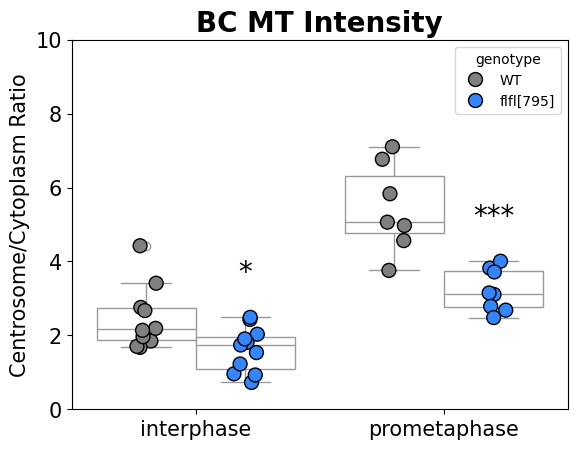

In [7]:
# plotting
o = ['interphase', 'prometaphase']
ho = ['WT', 'flfl[795]']
p = ['grey', '#3386FF']

sns.stripplot(x = 'phase', y = 'BC RFP norm', data = data,
             hue = 'genotype', hue_order = ho, order = o, palette = p,
             dodge = True, legend = True,
             linewidth = 1, edgecolor = 'k', size = 10);

sns.boxplot(x = 'phase', y = 'BC RFP norm', data = data,
             hue = 'genotype', hue_order = ho, order = o, palette = ['w', 'w'],
             dodge = True, legend = False);

# stat time, interphase
param1 = data[(data['genotype']=='WT') & (data['phase']=='interphase')]['BC RFP norm']
param2 = data[(data['genotype']=='flfl[795]') & (data['phase']=='interphase')]['BC RFP norm']
int_p = independent_ttest(param1, param2, 0.05)[3]

if int_p < 0.001:
    plt.annotate('***', fontsize = 20, ha = 'center', xy = (0.2, param2.max()+1))
elif int_p < 0.01:
    plt.annotate('**', fontsize = 20, ha = 'center', xy = (0.2, param2.max()+1))
elif int_p < 0.05:
    plt.annotate('*', fontsize = 20, ha = 'center', xy = (0.2, param2.max()+1))
elif int_p > 0.05:
    plt.annotate(f"ns, p = {int_p}", fontsize = 10, ha = 'center', xy = (0.2, param2.max()+1))

# stat time, prometaphase
param1 = data[(data['genotype']=='WT') & (data['phase']=='prometaphase')]['BC RFP norm']
param2 = data[(data['genotype']=='flfl[795]') & (data['phase']=='prometaphase')]['BC RFP norm']
int_p = independent_ttest(param1, param2, 0.05)[3]

if int_p < 0.001:
    plt.annotate('***', fontsize = 20, ha = 'center', xy = (1.2, param2.max()+1))
elif int_p < 0.01:
    plt.annotate('**', fontsize = 20, ha = 'center', xy = (1.2, param2.max()+1))
elif int_p < 0.05:
    plt.annotate('*', fontsize = 20, ha = 'center', xy = (1.2, param2.max()+1))
elif int_p > 0.05:
    plt.annotate(f"ns, p = {int_p}", fontsize = 10, ha = 'center', xy = (1.2, param2.max()+1))

# axis labels

plt.xlabel('')
plt.ylabel('Centrosome/Cytoplasm Ratio', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('BC MT Intensity', fontweight = 'bold', fontsize = 20)
plt.ylim(0,10)

os.chdir(figs_dir)

plt.savefig('BC intensity.svg', dpi = 600, bbox_inches = 'tight')
plt.show();

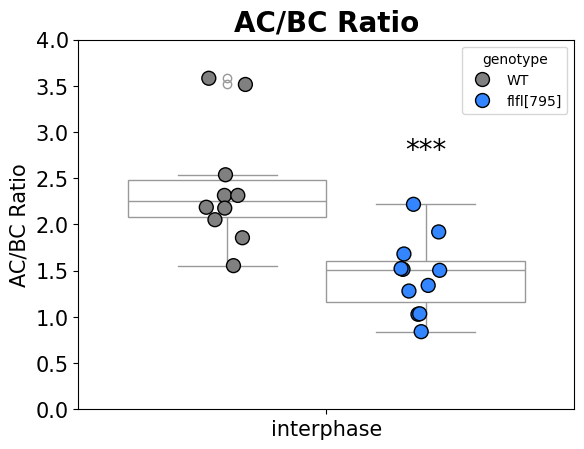

In [8]:
# plotting
o = ['interphase']
ho = ['WT', 'flfl[795]']
p = ['grey', '#3386FF']

sns.stripplot(x = 'phase', y = 'AC/BC', data = data,
             hue = 'genotype', hue_order = ho, order = o, palette = p,
             dodge = True, legend = True,
             linewidth = 1, edgecolor = 'k', size = 10);

sns.boxplot(x = 'phase', y = 'AC/BC', data = data,
             hue = 'genotype', hue_order = ho, order = o, palette = ['w', 'w'],
             dodge = True, legend = False);

# stat time, interphase
param1 = data[(data['genotype']=='WT') & (data['phase']=='interphase')]['AC/BC']
param2 = data[(data['genotype']=='flfl[795]') & (data['phase']=='interphase')]['AC/BC']
int_p = independent_ttest(param1, param2, 0.05)[3]

if int_p < 0.001:
    plt.annotate('***', fontsize = 20, ha = 'center', xy = (0.2, param2.max()+0.5))
elif int_p < 0.01:
    plt.annotate('**', fontsize = 20, ha = 'center', xy = (0.2, param2.max()+0.5))
elif int_p < 0.05:
    plt.annotate('*', fontsize = 20, ha = 'center', xy = (0.2, param2.max()+0.5))
elif int_p > 0.05:
    plt.annotate(f"ns, p = {int_p}", fontsize = 10, ha = 'center', xy = (0.2, param2.max()+0.5))

# stat time, prometaphase
param1 = data[(data['genotype']=='WT') & (data['phase']=='prometaphase')]['AC/BC']
param2 = data[(data['genotype']=='flfl[795]') & (data['phase']=='prometaphase')]['AC/BC']
int_p = independent_ttest(param1, param2, 0.05)[3]

if int_p < 0.001:
    plt.annotate('***', fontsize = 20, ha = 'center', xy = (1.2, param2.max()+0.5))
elif int_p < 0.01:
    plt.annotate('**', fontsize = 20, ha = 'center', xy = (1.2, param2.max()+0.5))
elif int_p < 0.05:
    plt.annotate('*', fontsize = 20, ha = 'center', xy = (1.2, param2.max()+0.5))
elif int_p > 0.05:
    plt.annotate(f"ns, p = {np.round(int_p, decimals = 3)}", fontsize = 10, ha = 'center', xy = (1.2, param2.max()+0.5))

# axis labels

plt.xlabel('')
plt.ylabel('AC/BC Ratio', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('AC/BC Ratio', fontweight = 'bold', fontsize = 20)
plt.ylim(0,4)

os.chdir(figs_dir)

plt.savefig('AC BC ratio.svg', dpi = 600, bbox_inches = 'tight')
plt.show();

## Statistical Table

In [9]:
data.head(5)

,file name,genotype,phase,AC RFP mean,BC RFP mean,AC RFP norm,BC RFP norm,AC/BC
0,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,947.675,376.914,5.651167,1.846093,3.515319
1,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,991.105,513.405,5.940700,2.756033,2.314511
2,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,1006.840,611.579,6.045600,3.410527,1.856324
3,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,756.283,428.459,4.375220,2.189727,2.177279
4,"Flfl795_3_pos1-4 WT, pos5-8 Flfl795 - Position 1",WT,interphase,869.279,500.579,5.128527,2.670527,2.051689


In [10]:
stats_table = pd.DataFrame(columns = ['control variable', 'experimental variable', 'phase', 'test', 'y-value',
                                      'control n', 'experimental n',
                                      'control mean', 'experimental mean',
                                     'control stdev', 'experimental stdev',
                                     'test statistic', 'degrees of freedom', 
                                     'critical value', 'p-value'])

pd.set_option('display.float_format', '{:.2E}'.format) # enables scientific notation

stats_table

,control variable,experimental variable,phase,test,y-value,control n,experimental n,control mean,experimental mean,control stdev,experimental stdev,test statistic,degrees of freedom,critical value,p-value


In [11]:
# test# = [control genotype, experimental genotype, phase, y-value]
t1 = ['WT', 'flfl[795]', 'interphase', 'AC RFP norm']
t2 = ['WT', 'flfl[795]', 'interphase', 'AC/BC']

tests = [t1, t2]

In [12]:
for i in range(0, len(tests)):
    stats_table.loc[i, 'control variable'] = tests[i][0]
    stats_table.loc[i, 'experimental variable'] = tests[i][1]
    stats_table.loc[i, 'phase'] = tests[i][2]
    stats_table.loc[i, 'y-value'] = tests[i][3]
    
    param1 = data[(data['genotype']==tests[i][0]) & (data['phase']==tests[i][2])][tests[i][3]].dropna()
    param2 = data[(data['genotype']==tests[i][1]) & (data['phase']==tests[i][2])][tests[i][3]].dropna()

    stats_table.loc[i, 'control n'] = len(param1)
    stats_table.loc[i, 'experimental n'] = len(param2)

    stats_table.loc[i, 'control mean'] = param1.mean()
    stats_table.loc[i, 'experimental mean'] = param2.mean()

    stats_table.loc[i, 'control stdev'] = param1.std()
    stats_table.loc[i, 'experimental stdev'] = param2.std()

    test = independent_ttest(param1, param2, 0.05)
    stats_table.loc[i, 'test statistic'] = test[0]
    stats_table.loc[i, 'degrees of freedom'] = test[1]
    stats_table.loc[i, 'critical value'] = test[2]
    stats_table.loc[i, 'p-value'] = test[3]


    if test[3] < 0.0001:
        sig = "****"
    elif test[3] < 0.001:
        sig = "***"
    elif test[3] < 0.01:
        sig = "**"
    elif test[3] < 0.05:
        sig = "*"
    elif test[3] > 0.05:
        sig = "ns"
    stats_table.loc[i, 'significance'] = sig
    
stats_table['test'] = "Unpaired Student's T-test"
stats_table

,control variable,experimental variable,phase,test,y-value,control n,experimental n,control mean,experimental mean,control stdev,experimental stdev,test statistic,degrees of freedom,critical value,p-value,significance
0,WT,flfl[795],interphase,Unpaired Student's T-test,AC RFP norm,10,11,5.13E+00,2.04E+00,1.00E+00,6.52E-01,8.29E+00,19,1.73E+00,9.76E-08,****
1,WT,flfl[795],interphase,Unpaired Student's T-test,AC/BC,10,11,2.41E+00,1.44E+00,6.58E-01,4.05E-01,4.00E+00,19,1.73E+00,7.68E-04,***


In [13]:
# saves output stats table
os.chdir(outs_dir)
stats_table.to_csv('Flfl[795] mutant stats.csv')
os.chdir(home_dir)